<a href="https://colab.research.google.com/github/visaasmara/Skripsi/blob/main/MARET_SKRIPSI_TANPA_PENANGANAN_OUTLIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Data Preparation**



In [21]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

#Read Data
transaksi = pd.read_excel('/content/drive/MyDrive/Data Koperasi/data_penjualan_maret.xlsx', header = 0, usecols = 'B,C,D,I')

#Preview Data
transaksi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TANGGAL,STRUK,KODE BARANG,SUBTOTAL
0,2023-03-01,723,8999999053031,28000
1,2023-03-01,805,8991002105645,11800
2,2023-03-01,805,663300,18500
3,2023-03-01,1053,8999999589189,16000
4,2023-03-01,1053,8999999045920,24000
...,...,...,...,...
32312,2023-03-31,1522,8998866201520,10600
32313,2023-03-31,1522,8992946530357,17000
32314,2023-03-31,1522,8993110071126,19000
32315,2023-03-31,1522,8998866670777,7000


In [22]:
#Info of Data
transaksi.info()

#Description of Data
transaksi.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32317 entries, 0 to 32316
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TANGGAL      32317 non-null  datetime64[ns]
 1   STRUK        32317 non-null  int64         
 2   KODE BARANG  32317 non-null  object        
 3   SUBTOTAL     32317 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1010.0+ KB


,TANGGAL,STRUK,SUBTOTAL
count,32317,32317.000000,3.231700e+04
mean,2023-03-14 22:48:04.946003712,1445.180988,1.478375e+04
min,2023-03-01 00:00:00,653.000000,0.000000e+00
25%,2023-03-06 00:00:00,1047.000000,4.700000e+03
50%,2023-03-15 00:00:00,1454.000000,8.500000e+03
75%,2023-03-23 00:00:00,1842.000000,1.700000e+04
max,2023-03-31 00:00:00,2057.000000,2.540000e+06
std,NaN,414.232779,2.963997e+04


### **2. Penanganan Missing Value**

In [23]:
#Check Missing Value
transaksi.isnull()
transaksi.isnull().sum()

TANGGAL        0
STRUK          0
KODE BARANG    0
SUBTOTAL       0
dtype: int64

In [24]:
#Drop Row with Missing Value
transaksi = transaksi.dropna()
transaksi.shape

(32317, 4)

### **3. Perhitungan RFM**

### Recency

In [25]:
transaksi['KODE BARANG'] = transaksi['KODE BARANG'].astype("string")
rfm_r = transaksi.groupby(by='KODE BARANG',
						as_index=False)['TANGGAL'].max()
rfm_r.columns = ['KODE BARANG', 'LastPurchaseDate']
recent_date = rfm_r['LastPurchaseDate'].max()
rfm_r['Recency'] = rfm_r['LastPurchaseDate'].apply(
	lambda x: (recent_date - x).days)
rfm_r.sort_values(by='KODE BARANG', ascending=True)

,KODE BARANG,LastPurchaseDate,Recency
0,0,2023-03-23,8
1,1,2023-03-16,15
2,100004,2023-03-30,1
3,100008,2023-03-31,0
4,10003,2023-03-10,21
...,...,...,...
6418,995,2023-03-18,13
6419,99991,2023-03-23,8
6420,99997,2023-03-27,4
6421,CABRP.23.900,2023-03-29,2


### Frequency

In [26]:
#Calculate The Frequency
transaksi['STRUK '] = transaksi['STRUK'].astype("string")
rfm_f = transaksi.groupby(
    by=['KODE BARANG'], as_index=False)['STRUK'].count()
rfm_f.columns = ['KODE BARANG', 'Frequency']
rfm_f['Frequency'] = rfm_f['Frequency'].astype("int")
rfm_f.sort_values(by='KODE BARANG', ascending=True)

,KODE BARANG,Frequency
0,0,1
1,1,3
2,100004,6
3,100008,27
4,10003,1
...,...,...
6418,995,1
6419,99991,2
6420,99997,3
6421,CABRP.23.900,1


### Monetary

In [27]:
# Calculate The Monetary
transaksi['Monetary'] = transaksi['SUBTOTAL']
rfm_m = transaksi.groupby('KODE BARANG')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m['Monetary'] = rfm_m['Monetary'].astype("int")
rfm_m.sort_values(by='KODE BARANG', ascending=True)

,KODE BARANG,Monetary
0,0,10500
1,1,34500
2,100004,135000
3,100008,495000
4,10003,128500
...,...,...
6418,995,13500
6419,99991,20000
6420,99997,10500
6421,CABRP.23.900,16500


### Merging RFM

In [28]:
rfm_rf = pd.merge(rfm_r,rfm_f, on='KODE BARANG', how='inner').drop(
     columns='LastPurchaseDate')
# rfm_rf = pd.merge(rfm_r, rfm_f, on='KODE BARANG', how='inner')
rfm_rf.columns = ['KODE BARANG','Recency', 'Frequency']
rfm_rfm = rfm_rf.merge(rfm_m, on='KODE BARANG', how='inner')
rfm_rfm.columns = ['KODE BARANG','Recency', 'Frequency', 'Monetary']
rfm_rfm

,KODE BARANG,Recency,Frequency,Monetary
0,0,8,1,10500
1,1,15,3,34500
2,100004,1,6,135000
3,100008,0,27,495000
4,10003,21,1,128500
...,...,...,...,...
6418,995,13,1,13500
6419,99991,8,2,20000
6420,99997,4,3,10500
6421,CABRP.23.900,2,1,16500


In [29]:
import seaborn as sns
import numpy as np
from scipy import stats

rfm = rfm_rfm[['Recency','Frequency', 'Monetary']]

In [30]:
import sklearn
from sklearn.preprocessing import StandardScaler

# Instantiate
scaler = StandardScaler()

# fit_transform
rfmscaled = scaler.fit_transform(rfm)
rfmscaled.shape

rfmscaled = pd.DataFrame(rfmscaled)
rfmscaled.columns = ['Recency','Frequency', 'Monetary']
rfmscaled.head()


,Recency,Frequency,Monetary
0,-0.244568,-0.484004,-0.322895
1,0.551552,-0.243890,-0.201589
2,-1.040687,0.116281,0.306380
3,-1.154418,2.637480,2.125971
4,1.233940,-0.484004,0.273527


<Axes: >

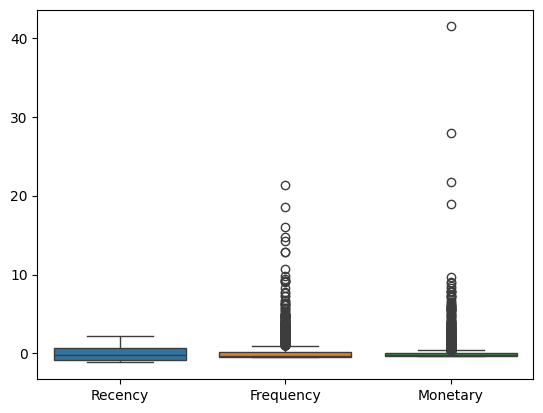

In [31]:
sns.boxplot(rfmscaled)

### **4. K-Means Clustering**

### Elbow Method : Find K

In [32]:
# Elbow-curve/SSD
from sklearn.cluster import KMeans

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfmscaled)

    ssd.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

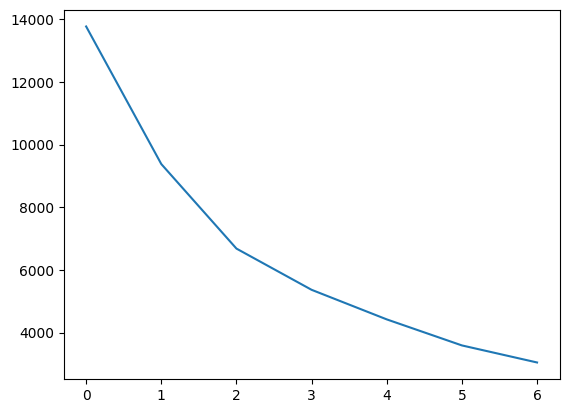

In [33]:
import matplotlib.pyplot as plt
plt.plot(ssd)

### Silhouette Coefficient

In [34]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfmscaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfmscaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=2, the silhouette score is 0.44709237353094783


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=3, the silhouette score is 0.4923957911267256


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=4, the silhouette score is 0.5213648724193282


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=5, the silhouette score is 0.5017523967733049


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=6, the silhouette score is 0.5081254257396806


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=7, the silhouette score is 0.42087312885571304


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=8, the silhouette score is 0.4279169252830727


### Clustering

In [35]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfmscaled)

kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([1, 3, 1, ..., 1, 1, 3], dtype=int32)

In [36]:
# assign the label
rfmscaled['Cluster'] = kmeans.labels_
rfmscaled.columns = ['Recency', 'Frequency', 'Monetary', 'Cluster']
rfmscaled

,Recency,Frequency,Monetary,Cluster
0,-0.244568,-0.484004,-0.322895,1
1,0.551552,-0.243890,-0.201589,3
2,-1.040687,0.116281,0.306380,1
3,-1.154418,2.637480,2.125971,0
4,1.233940,-0.484004,0.273527,3
...,...,...,...,...
6418,0.324089,-0.484004,-0.307732,1
6419,-0.244568,-0.363947,-0.274878,1
6420,-0.699493,-0.243890,-0.322895,1
6421,-0.926956,-0.484004,-0.292568,1


In [37]:
final = pd.concat([rfm_rfm, rfmscaled['Cluster']], axis=1)
final

,KODE BARANG,Recency,Frequency,Monetary,Cluster
0,0,8,1,10500,1
1,1,15,3,34500,3
2,100004,1,6,135000,1
3,100008,0,27,495000,0
4,10003,21,1,128500,3
...,...,...,...,...,...
6418,995,13,1,13500,1
6419,99991,8,2,20000,1
6420,99997,4,3,10500,1
6421,CABRP.23.900,2,1,16500,1


      Recency  Frequency  Monetary  Cluster
0           8          1     10500        1
1          15          3     34500        3
2           1          6    135000        1
3           0         27    495000        0
4          21          1    128500        3
...       ...        ...       ...      ...
6418       13          1     13500        1
6419        8          2     20000        1
6420        4          3     10500        1
6421        2          1     16500        1
6422       15          1     10500        3

[6423 rows x 4 columns]


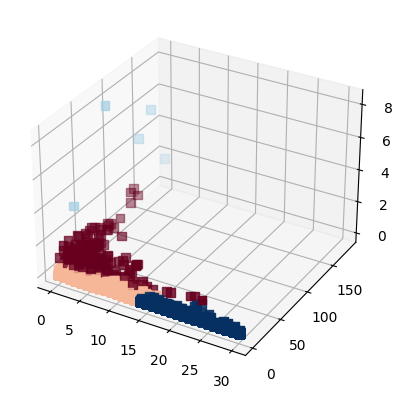

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# v = np.random.rand(10,4)
# v[:,3] = np.random.randint(0,2,size=10)
df = pd.DataFrame(final, columns=['Recency', 'Frequency','Monetary',"Cluster"])
print (df)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(df['Recency'])
y = np.array(df['Frequency'])
z = np.array(df['Monetary'])

ax.scatter(x,y,z, marker="s", c=df["Cluster"], s=40, cmap="RdBu")

plt.show()

In [39]:
import plotly.express as px
#df = px.rfmscaled
fig = px.scatter_3d(final, x='Recency', y='Frequency', z='Monetary',
              color='Cluster')
fig.show()

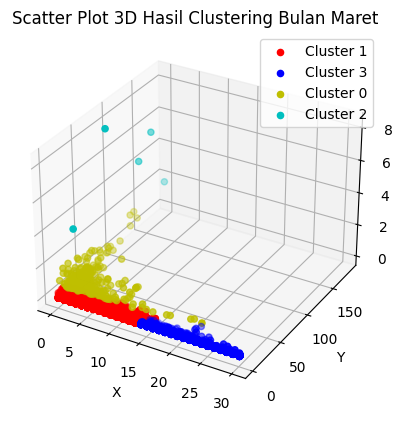

In [40]:
data = pd.DataFrame(final, columns=['Recency', 'Frequency','Monetary',"Cluster"])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Setiap cluster akan memiliki warna yang berbeda
colors = ['r','b', 'y', 'c', 'm']

for cluster_label, color in zip(data['Cluster'].unique(), colors):
    cluster_data = data[data['Cluster'] == cluster_label]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster_label}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Scatter Plot 3D Hasil Clustering Bulan Maret')
plt.legend()
plt.show()